In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# importing the libraries for transformation
#https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
#from torchsummary import summary
import pandas as pd
import numpy as np
#from tqdm import tqdm

#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate, rescale, resize #, downscale_local_mean
#from skimage.util import random_noise
#from skimage.filters import gaussian
#from scipy import ndimage

In [ ]:
# importing all the required libraries
import warnings
warnings.filterwarnings('ignore')
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
#import torchvision.transforms.functional as fn

In [ ]:
# paths for (labeled) training & validation data.
train_path = '/content/drive/MyDrive/FashionClassification/Train/'
valid_path = '/content/drive/MyDrive/FashionClassification/Validation/'

In [ ]:
# prepare training data set
classes = ['Resort', 'Retro', 'Sporty']

data =[]
label =[]

## i : Integer representation for each classes (Resort/Retro/Sporty -> 0/1/2)
for i, d in enumerate(classes):
    files = os.listdir(train_path+'/'+d)
    
    for f in files:
        img = Image.open(train_path+'/'+d+'/'+f,'r')
        img = img.resize((150, 150))
        one_img = np.asarray(np.float32(img))
        norm_img = (one_img-np.min(one_img))/(np.max(one_img)-np.min(one_img))
        data.append(norm_img)
        #img = np.asarray(np.float32(img))
       # data.append(img.transpose(2,0,1))  # (150,150,3) --> (3,150,150)
        label.append(i)

data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')
"""
train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
"""

'\ntrain_X = torch.from_numpy(data) #numpy to tensor\ntrain_Y = torch.from_numpy(label)\n\ntrain_X = train_X.type(torch.cuda.FloatTensor) #32bit\ntrain_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss\n\ntrain_dataset = TensorDataset(train_X,train_Y)\ntrain_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)\n'

In [ ]:
data.shape, label.shape  # check

((5910, 150, 150, 3), (5910,))

In [ ]:
final_train_data = []
final_train_label = []
for i in range(data.shape[0]):
    final_train_data.append(data[i])
    
    final_train_data.append(np.fliplr(data[i]))
    
    transform = AffineTransform(translation=(16,16))
    wrapShift = warp(data[i],transform,mode='wrap')
    final_train_data.append(wrapShift)
    
    for j in range(3):
        final_train_label.append(label[i])

In [ ]:
final_train = np.array(final_train_data, dtype='float32')
final_label = np.array(final_train_label, dtype='int64')

In [ ]:
len(final_train), len(final_label)

(21600, 21600)

In [ ]:
del data, label, img

(-0.5, 149.5, 149.5, -0.5)

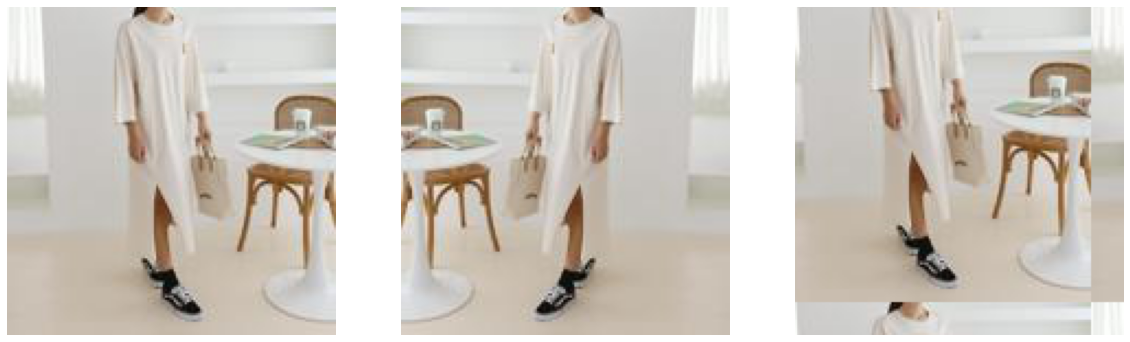

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,20))
check_data=final_train_data[0]
ax[0].imshow(check_data)
ax[0].axis('off')

check_data=np.fliplr(final_train_data[0])
ax[1].imshow(check_data)
ax[1].axis('off')

transform = AffineTransform(translation=(15,15))
wrapShift = warp(final_train_data[0],transform,mode='wrap')
ax[2].imshow(wrapShift)
ax[2].axis('off')

In [ ]:
final_train=final_train.transpose(0,3,1,2)  # (150,150,3) --> (3,150,150)

In [ ]:
train_X = torch.from_numpy(final_train) #numpy to tensor
del final_train
train_Y = torch.from_numpy(final_label)
del final_label
train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
"""
# Display images
# Not necessary for training. Just for confirmation
for images, labels in train_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        print(f'Label = {l[0]} : {classes[l[0]]}')
        plt.imshow(i[0,0,:,:])
        plt.show()
        """

"\n# Display images\n# Not necessary for training. Just for confirmation\nfor images, labels in train_loader:\n        i, l = Variable(images), Variable(labels)\n        print(i.size())\n        i = i.cpu().numpy()\n        l = l.cpu().numpy()\n        print(f'Label = {l[0]} : {classes[l[0]]}')\n        plt.imshow(i[0,0,:,:])\n        plt.show()\n        "

In [ ]:
# prepare validation data set
data =[]
label =[]

for i, d in enumerate(classes):
    files = os.listdir(valid_path+'/'+d)
    
    for f in files:
        img = Image.open(valid_path+'/'+d+'/'+f,'r')
        img = img.resize((150, 150))
        #img = np.asarray(np.float32(img))
        one_img = np.asarray(np.float32(img))
        norm_img = (one_img-np.min(one_img))/(np.max(one_img)-np.min(one_img))
        data.append(norm_img.transpose(2,0,1)) # (150,150,3) --> (3,150,150)
        label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
data.shape, label.shape  # check

((1800, 3, 150, 150), (1800,))

In [ ]:
"""
# Display images
# Not necessary for training. Just for confirmation
for images, labels in valid_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        print(f'Label = {l[0]} : {classes[l[0]]}')
        plt.imshow(i[0,0,:,:])
        plt.show()
        """

"\n# Display images\n# Not necessary for training. Just for confirmation\nfor images, labels in valid_loader:\n        i, l = Variable(images), Variable(labels)\n        print(i.size())\n        i = i.cpu().numpy()\n        l = l.cpu().numpy()\n        print(f'Label = {l[0]} : {classes[l[0]]}')\n        plt.imshow(i[0,0,:,:])\n        plt.show()\n        "

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(8192, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 3)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.5)
        x = self.fc3(x)
        return x

model = Net()

In [ ]:
"""
# Build convolutional neural net
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
           #3 224 128
          nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
          nn.MaxPool2d(2, 2),
            #64 112 64
          nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
          nn.MaxPool2d(2, 2),
            #128 56 32
          nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
          nn.MaxPool2d(2, 2),
            #256 28 16
          nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
          nn.MaxPool2d(2, 2),
            #512 14 8
          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
          nn.MaxPool2d(2, 2)
        )
        #512 7 4
        
      #  self.avg_pool = nn.AvgPool2d(7)
        #512 1 1
       # self.fc = nn.Linear(512,3)
        
        
        self.fc1 = nn.Linear(512*2*2,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear4096,3)
     
     
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
       


model = Net()
"""

'\n# Build convolutional neural net\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv = nn.Sequential(\n           #3 224 128\n          nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.MaxPool2d(2, 2),\n            #64 112 64\n          nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.MaxPool2d(2, 2),\n            #128 56 32\n          nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.MaxPool2d(2, 2),\n            #256 28 16\n          nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),\n          nn.MaxPool

In [ ]:
# Print the network you built
model.cuda()

Net(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_3): Conv2d(512, 512,

In [ ]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.005)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    #torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        print('Valid_Prediction : {}'.format(pred))
        print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

In [ ]:
import gc
gc.collect()
# cuda delete cache
torch.cuda.empty_cache()

***START EPOCH***
# Epoch : 0 /100
Valid_Prediction : [1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 0 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

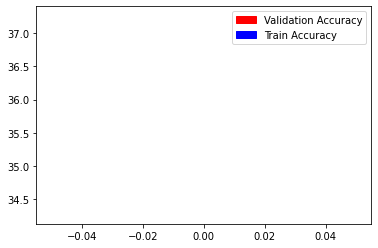

# Epoch : 1 /100
Valid_Prediction : [1 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

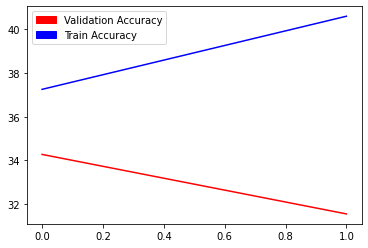

# Epoch : 2 /100
Valid_Prediction : [0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

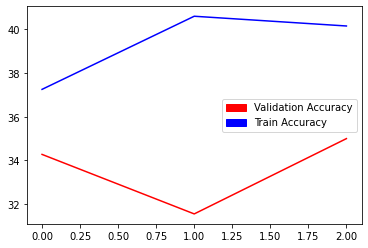

# Epoch : 3 /100
Valid_Prediction : [0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

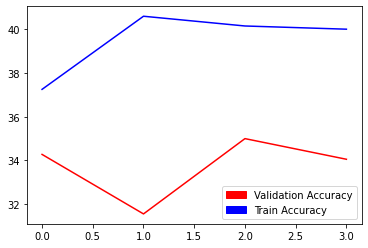

# Epoch : 4 /100
Valid_Prediction : [1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

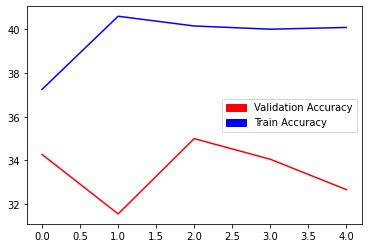

# Epoch : 5 /100
Valid_Prediction : [0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

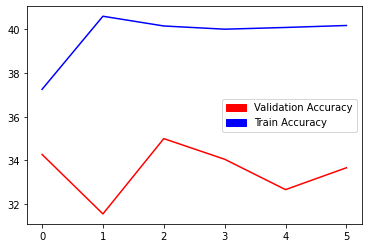

# Epoch : 6 /100
Valid_Prediction : [0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

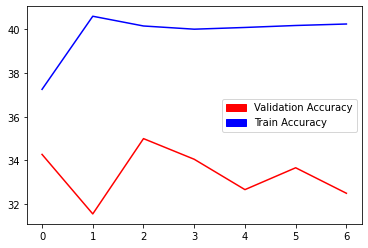

# Epoch : 7 /100
Valid_Prediction : [0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

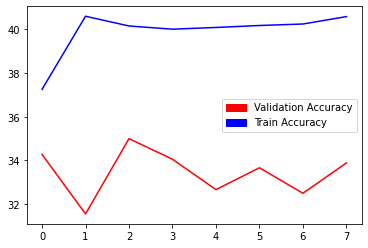

# Epoch : 8 /100
Valid_Prediction : [1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

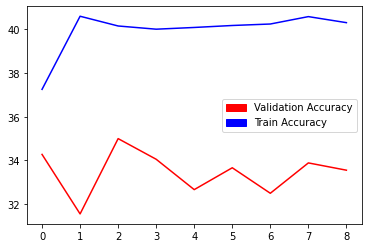

# Epoch : 9 /100
Valid_Prediction : [1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

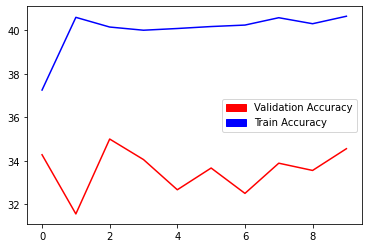

# Epoch : 10 /100
Valid_Prediction : [0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

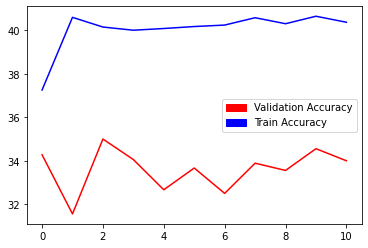

# Epoch : 11 /100
Valid_Prediction : [1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

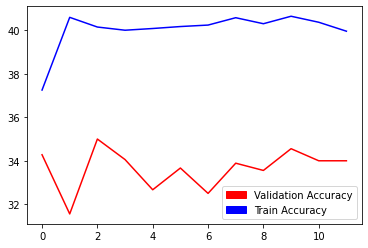

# Epoch : 12 /100
Valid_Prediction : [1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

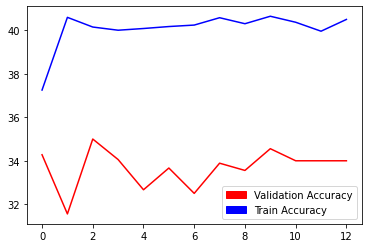

# Epoch : 13 /100
Valid_Prediction : [1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

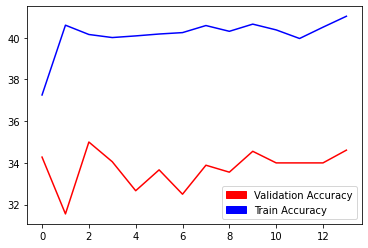

# Epoch : 14 /100
Valid_Prediction : [0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Valid_Prediction : [0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

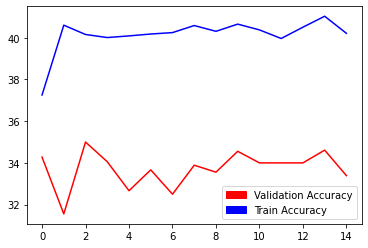

# Epoch : 15 /100


In [ ]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(100):
    print('# Epoch : {} /100'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/MyDrive/FashionClassification/Model_TeamK')

# TEST

In [ ]:
# Path for (unlabeled) test data
#test_path = '/content/drive/MyDrive/FashionClassification/Test/'

In [ ]:
"""
import re
def num_sort(test_string):
    return list(map(int, re.findall(r'\d+', test_string)))[0]
    """